### Import

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Preparation

In [25]:
tools = pd.read_csv('./data/tools.csv')
fpmms = pd.read_csv('./data/fpmms.csv')
summary_traders = pd.read_csv('./data/summary_profitability.csv')
all_trades = pd.read_csv('./data/all_trades_profitability.csv')

In [26]:
print(tools.shape)
tools.request_block.min(), tools.request_block.max()

(235483, 22)


(28911882, 33447994)

### 1. Error analysis

Error analysis only starts from block 321. We weren't capturing the error message prior

In [27]:
tools.tool.unique()

array(['prediction-online', 'prediction-offline', 'normal-sme-generator',
       'strong-sme-generator', 'prediction-online-sme',
       'prediction-offline-sme', 'claude-prediction-offline', 'openai',
       'claude-prediction-online',
       'prediction-sentence-embedding-conservative',
       'prediction-online-summarized-info',
       'prediction-sentence-embedding-bold',
       'prediction-online-sum-url-content',
       'openai-gpt-3.5-turbo-instruct',
       'resolve-market-reasoning-gpt-3.5-turbo',
       'resolve-market-reasoning-gpt-4', 'prediction-request-rag',
       'prediction-request-reasoning',
       'prediction-request-reasoning-claude', 'prediction-url-cot-claude',
       'prediction-request-rag-claude', 'native_transfer_request',
       'native_transfer'], dtype=object)

In [28]:
inc_tools = [
    'prediction-online', 
    'prediction-offline', 
    'claude-prediction-online', 
    'claude-prediction-offline', 
    'prediction-offline-sme',
    'prediction-online-sme',
    'prediction-request-rag',
    'prediction-request-reasoning',
    'prediction-url-cot-claude', 
    'prediction-request-rag-claude',
    'prediction-request-reasoning-claude'
]

In [29]:
def set_error(row):
    if row.error not in [True, False]:
        if not row.prompt_response:
            return True
        return False
    return row.error

In [30]:
# include only tools that are in inc_tools
tools_inc = tools[tools['tool'].isin(inc_tools)]
# set error column; for earlier tool calls there error is when there are no prompt_response
tools_inc['error'] = tools_inc.apply(set_error, axis=1)

In [31]:
error = tools_inc.groupby(['tool', 'request_month_year_week', 'error']).size().unstack().fillna(0).reset_index()
error['error_perc'] = (error[True] / (error[False] + error[True]))*100
error['total_requests'] = error[False] + error[True]

In [32]:
error_total = error.groupby('request_month_year_week').agg({'total_requests': 'sum', False: 'sum', True:'sum'}).reset_index()
error_total['error_perc'] = (error_total[True] / error_total['total_requests'])*100
error_total

error request_month_year_week  total_requests     False     True  error_perc
0       2023-07-10/2023-07-16          44.000    13.000   31.000      70.455
1       2023-07-17/2023-07-23          56.000    56.000    0.000       0.000
2       2023-07-24/2023-07-30          48.000    43.000    5.000      10.417
3       2023-07-31/2023-08-06         922.000   719.000  203.000      22.017
4       2023-08-07/2023-08-13         313.000   304.000    9.000       2.875
5       2023-08-14/2023-08-20        1518.000  1416.000  102.000       6.719
6       2023-08-21/2023-08-27        1340.000  1187.000  153.000      11.418
7       2023-08-28/2023-09-03        1588.000  1581.000    7.000       0.441
8       2023-09-04/2023-09-10        4776.000  4449.000  327.000       6.847
9       2023-09-11/2023-09-17        6008.000  5956.000   52.000       0.866
10      2023-09-18/2023-09-24        8278.000  7973.000  305.000       3.684
11      2023-09-25/2023-10-01        4516.000  3827.000  689.000      15.257
12      2023-10-02/2023-10-08        6257.000  4985.000 1272.000      20.329
13      2023-10-09/2023-10-15        6992.000  4889.000 2103.000      30.077
14      2023-10-16/2023-10-22        4966.000  4001.000  965.000      19.432
15      2023-10-23/2023-10-29        3235.000  2855.000  380.000      11.747
16      2023-10-30/2023-11-05        1767.000  1659.000  108.000       6.112
17      2023-11-06/2023-11-12        3868.000  3517.000  351.000       9.074
18      2023-11-13/2023-11-19        4596.000  4557.000   39.000       0.849
19      2023-11-20/2023-11-26        4135.000  4058.000   77.000       1.862
20      2023-11-27/2023-12-03        4080.000  3926.000  154.000       3.775
21      2023-12-04/2023-12-10        4566.000  4242.000  324.000       7.096
22      2023-12-11/2023-12-17        4985.000  4224.000  761.000      15.266
23      2023-12-18/2023-12-24        4175.000  3086.000 1089.000      26.084
24      2023-12-25/2023-12-31        2944.000  2749.000  195.000       6.624
25      2024-01-01/2024-01-07        4240.000  4160.000   80.000       1.887
26      2024-01-08/2024-01-14        2101.000  2040.000   61.000       2.903
27      2024-01-15/2024-01-21        4283.000  4200.000   83.000       1.938
28      2024-01-22/2024-01-28        4305.000  4215.000   90.000       2.091
29      2024-01-29/2024-02-04        4500.000  4389.000  111.000       2.467
30      2024-02-05/2024-02-11        4729.000  4641.000   88.000       1.861
31      2024-02-12/2024-02-18        6581.000  5106.000 1475.000      22.413
32      2024-02-19/2024-02-25        7504.000  3920.000 3584.000      47.761
33      2024-02-26/2024-03-03        5907.000  4660.000 1247.000      21.111
34      2024-03-04/2024-03-10        8457.000  8073.000  384.000       4.541
35      2024-03-11/2024-03-17       10036.000  9620.000  416.000       4.145
36      2024-03-18/2024-03-24       12808.000 12313.000  495.000       3.865
37      2024-03-25/2024-03-31       23114.000 16445.000 6669.000      28.853
38      2024-04-01/2024-04-07       20486.000 15069.000 5417.000      26.442
39      2024-04-08/2024-04-14       23021.000 15914.000 7107.000      30.872
40      2024-04-15/2024-04-21          49.000    46.000    3.000       6.122

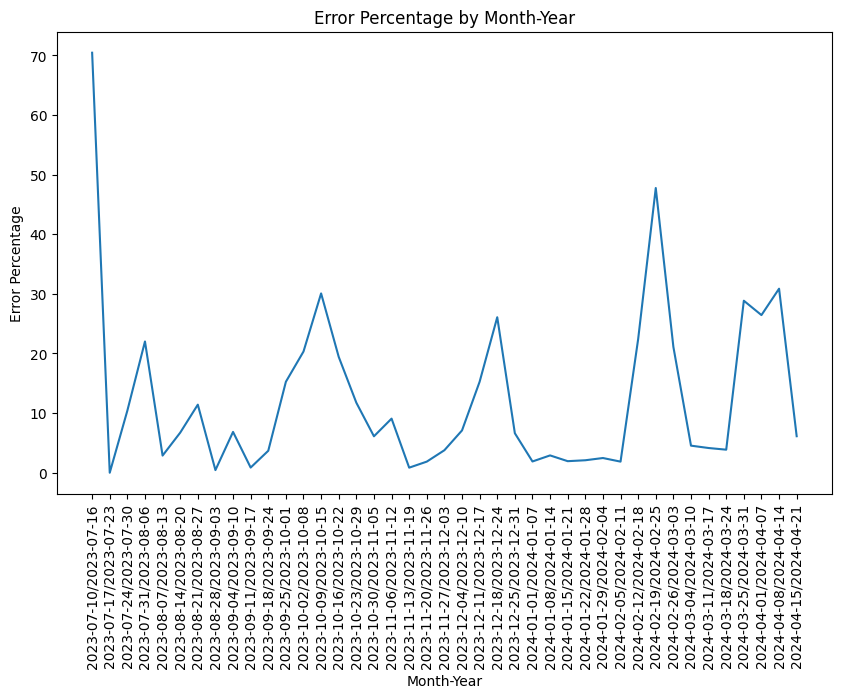

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(error_total['request_month_year_week'], error_total['error_perc'], label='Error Percentage')
plt.xlabel('Month-Year')
plt.ylabel('Error Percentage')
plt.title('Error Percentage by Month-Year')
plt.xticks(rotation=90)
plt.show()

In [34]:
error[error['request_month_year_week'] == '2024-04-08/2024-04-14'].groupby('tool').agg({'error_perc': 'mean', 'total_requests': 'sum'}).sort_values('error_perc', ascending=False)

error                                error_perc  total_requests
tool                                                           
prediction-request-rag-claude            58.579        2069.000
prediction-online-sme                    42.047        2169.000
claude-prediction-online                 36.858        3234.000
prediction-request-reasoning-claude      34.929        3258.000
prediction-request-reasoning             32.874        4423.000
prediction-request-rag                   28.217        3101.000
prediction-url-cot-claude                12.427        2583.000
prediction-offline                        0.138        2180.000
prediction-offline-sme                    0.000           4.000

In [35]:
# clude-prediction-offline
claude_prediction_offline = error[error['tool'] == 'claude-prediction-offline']
claude_prediction_offline = claude_prediction_offline.sort_values('request_month_year_week')
claude_prediction_offline

error                       tool request_month_year_week   False    True  \
0      claude-prediction-offline   2023-09-18/2023-09-24  10.000   3.000   
1      claude-prediction-offline   2023-09-25/2023-10-01 412.000 161.000   
2      claude-prediction-offline   2023-10-02/2023-10-08 620.000 341.000   
3      claude-prediction-offline   2023-10-09/2023-10-15 725.000 396.000   
4      claude-prediction-offline   2023-10-16/2023-10-22 852.000 239.000   
5      claude-prediction-offline   2023-10-23/2023-10-29 572.000 171.000   
6      claude-prediction-offline   2023-10-30/2023-11-05 111.000  39.000   
7      claude-prediction-offline   2023-11-06/2023-11-12   1.000   0.000   
8      claude-prediction-offline   2023-11-13/2023-11-19   4.000   0.000   
9      claude-prediction-offline   2023-11-20/2023-11-26   2.000  16.000   
10     claude-prediction-offline   2023-11-27/2023-12-03   0.000   1.000   
11     claude-prediction-offline   2023-12-18/2023-12-24  18.000   0.000   
12     claude-prediction-offline   2024-03-25/2024-03-31   5.000   0.000   
13     claude-prediction-offline   2024-04-01/2024-04-07   3.000   1.000   

error  error_perc  total_requests  
0          23.077          13.000  
1          28.098         573.000  
2          35.484         961.000  
3          35.326        1121.000  
4          21.907        1091.000  
5          23.015         743.000  
6          26.000         150.000  
7           0.000           1.000  
8           0.000           4.000  
9          88.889          18.000  
10        100.000           1.000  
11          0.000          18.000  
12          0.000           5.000  
13         25.000           4.000

In [36]:
# claude-prediction-online
claude_prediction_online = error[error['tool'] == 'claude-prediction-online']
claude_prediction_online = claude_prediction_online.sort_values('request_month_year_week')
claude_prediction_online

error                      tool request_month_year_week    False     True  \
14     claude-prediction-online   2023-09-18/2023-09-24   73.000  177.000   
15     claude-prediction-online   2023-09-25/2023-10-01  103.000  433.000   
16     claude-prediction-online   2023-10-02/2023-10-08  200.000  875.000   
17     claude-prediction-online   2023-10-09/2023-10-15  717.000 1685.000   
18     claude-prediction-online   2023-10-16/2023-10-22  401.000  595.000   
19     claude-prediction-online   2023-10-23/2023-10-29   79.000  101.000   
20     claude-prediction-online   2023-10-30/2023-11-05   40.000   43.000   
21     claude-prediction-online   2023-11-13/2023-11-19    0.000    4.000   
22     claude-prediction-online   2023-11-20/2023-11-26    1.000   18.000   
23     claude-prediction-online   2023-11-27/2023-12-03   12.000  118.000   
24     claude-prediction-online   2023-12-04/2023-12-10   13.000  303.000   
25     claude-prediction-online   2023-12-11/2023-12-17    2.000  743.000   
26     claude-prediction-online   2023-12-18/2023-12-24    0.000 1080.000   
27     claude-prediction-online   2023-12-25/2023-12-31   51.000  147.000   
28     claude-prediction-online   2024-01-01/2024-01-07  299.000   68.000   
29     claude-prediction-online   2024-01-08/2024-01-14  235.000   56.000   
30     claude-prediction-online   2024-01-15/2024-01-21  352.000   66.000   
31     claude-prediction-online   2024-01-22/2024-01-28  324.000   81.000   
32     claude-prediction-online   2024-01-29/2024-02-04  293.000   65.000   
33     claude-prediction-online   2024-02-05/2024-02-11  310.000   71.000   
34     claude-prediction-online   2024-02-12/2024-02-18  353.000   88.000   
35     claude-prediction-online   2024-02-19/2024-02-25  808.000  999.000   
36     claude-prediction-online   2024-02-26/2024-03-03    0.000  933.000   
37     claude-prediction-online   2024-03-04/2024-03-10    0.000  112.000   
38     claude-prediction-online   2024-03-11/2024-03-17    0.000   32.000   
39     claude-prediction-online   2024-03-18/2024-03-24  945.000  117.000   
40     claude-prediction-online   2024-03-25/2024-03-31 5292.000 1654.000   
41     claude-prediction-online   2024-04-01/2024-04-07 4810.000 2412.000   
42     claude-prediction-online   2024-04-08/2024-04-14 2042.000 1192.000   
43     claude-prediction-online   2024-04-15/2024-04-21    1.000    0.000   

error  error_perc  total_requests  
14         70.800         250.000  
15         80.784         536.000  
16         81.395        1075.000  
17         70.150        2402.000  
18         59.739         996.000  
19         56.111         180.000  
20         51.807          83.000  
21        100.000           4.000  
22         94.737          19.000  
23         90.769         130.000  
24         95.886         316.000  
25         99.732         745.000  
26        100.000        1080.000  
27         74.242         198.000  
28         18.529         367.000  
29         19.244         291.000  
30         15.789         418.000  
31         20.000         405.000  
32         18.156         358.000  
33         18.635         381.000  
34         19.955         441.000  
35         55.285        1807.000  
36        100.000         933.000  
37        100.000         112.000  
38        100.000          32.000  
39         11.017        1062.000  
40         23.812        6946.000  
41         33.398        7222.000  
42         36.858        3234.000  
43          0.000           1.000

In [37]:
# prediction-offline
prediction_offline = error[error['tool'] == 'prediction-offline']
prediction_offline = prediction_offline.sort_values('request_month_year_week')
prediction_offline


error                tool request_month_year_week    False    True  \
44     prediction-offline   2023-07-10/2023-07-16    1.000   2.000   
45     prediction-offline   2023-07-31/2023-08-06   69.000   0.000   
46     prediction-offline   2023-08-07/2023-08-13    4.000   0.000   
47     prediction-offline   2023-08-28/2023-09-03    4.000   0.000   
48     prediction-offline   2023-09-04/2023-09-10    3.000   0.000   
49     prediction-offline   2023-09-11/2023-09-17   10.000   0.000   
50     prediction-offline   2023-09-18/2023-09-24  313.000   4.000   
51     prediction-offline   2023-09-25/2023-10-01  587.000   2.000   
52     prediction-offline   2023-10-02/2023-10-08 1035.000   9.000   
53     prediction-offline   2023-10-09/2023-10-15  659.000   1.000   
54     prediction-offline   2023-10-16/2023-10-22  649.000  33.000   
55     prediction-offline   2023-10-23/2023-10-29  311.000   3.000   
56     prediction-offline   2023-10-30/2023-11-05   51.000   0.000   
57     prediction-offline   2023-11-13/2023-11-19    3.000   0.000   
58     prediction-offline   2023-11-20/2023-11-26    7.000   0.000   
59     prediction-offline   2023-11-27/2023-12-03   24.000   0.000   
60     prediction-offline   2023-12-04/2023-12-10    1.000   0.000   
61     prediction-offline   2023-12-18/2023-12-24    8.000   0.000   
62     prediction-offline   2024-01-01/2024-01-07    1.000   0.000   
63     prediction-offline   2024-03-11/2024-03-17  436.000  22.000   
64     prediction-offline   2024-03-18/2024-03-24 2645.000 148.000   
65     prediction-offline   2024-03-25/2024-03-31 3006.000 832.000   
66     prediction-offline   2024-04-01/2024-04-07 2203.000  97.000   
67     prediction-offline   2024-04-08/2024-04-14 2177.000   3.000   

error  error_perc  total_requests  
44         66.667           3.000  
45          0.000          69.000  
46          0.000           4.000  
47          0.000           4.000  
48          0.000           3.000  
49          0.000          10.000  
50          1.262         317.000  
51          0.340         589.000  
52          0.862        1044.000  
53          0.152         660.000  
54          4.839         682.000  
55          0.955         314.000  
56          0.000          51.000  
57          0.000           3.000  
58          0.000           7.000  
59          0.000          24.000  
60          0.000           1.000  
61          0.000           8.000  
62          0.000           1.000  
63          4.803         458.000  
64          5.299        2793.000  
65         21.678        3838.000  
66          4.217        2300.000  
67          0.138        2180.000

In [38]:
# prediction-online
prediction_online = error[error['tool'] == 'prediction-online']
prediction_online = prediction_online.sort_values('request_month_year_week')
prediction_online

error               tool request_month_year_week    False    True  error_perc  \
85     prediction-online   2023-07-10/2023-07-16   12.000  29.000      70.732   
86     prediction-online   2023-07-17/2023-07-23   56.000   0.000       0.000   
87     prediction-online   2023-07-24/2023-07-30   43.000   5.000      10.417   
88     prediction-online   2023-07-31/2023-08-06  650.000 203.000      23.798   
89     prediction-online   2023-08-07/2023-08-13  300.000   9.000       2.913   
90     prediction-online   2023-08-14/2023-08-20 1416.000 102.000       6.719   
91     prediction-online   2023-08-21/2023-08-27 1187.000 153.000      11.418   
92     prediction-online   2023-08-28/2023-09-03 1577.000   7.000       0.442   
93     prediction-online   2023-09-04/2023-09-10 4446.000 327.000       6.851   
94     prediction-online   2023-09-11/2023-09-17 5946.000  52.000       0.867   
95     prediction-online   2023-09-18/2023-09-24 7435.000 118.000       1.562   
96     prediction-online   2023-09-25/2023-10-01 1552.000  65.000       4.020   
97     prediction-online   2023-10-02/2023-10-08 1091.000  16.000       1.445   
98     prediction-online   2023-10-09/2023-10-15 1140.000   8.000       0.697   
99     prediction-online   2023-10-16/2023-10-22 1062.000  44.000       3.978   
100    prediction-online   2023-10-23/2023-10-29  698.000  24.000       3.324   
101    prediction-online   2023-10-30/2023-11-05  723.000  17.000       2.297   
102    prediction-online   2023-11-06/2023-11-12 1848.000 189.000       9.278   
103    prediction-online   2023-11-13/2023-11-19 2327.000  14.000       0.598   
104    prediction-online   2023-11-20/2023-11-26 2086.000  24.000       1.137   
105    prediction-online   2023-11-27/2023-12-03 1193.000   9.000       0.749   
106    prediction-online   2023-12-04/2023-12-10  117.000   2.000       1.681   
107    prediction-online   2023-12-11/2023-12-17   29.000   0.000       0.000   
108    prediction-online   2023-12-18/2023-12-24   76.000   0.000       0.000   
109    prediction-online   2023-12-25/2023-12-31   55.000   2.000       3.509   
110    prediction-online   2024-01-01/2024-01-07    2.000   0.000       0.000   
111    prediction-online   2024-01-22/2024-01-28    1.000   0.000       0.000   
112    prediction-online   2024-02-19/2024-02-25    0.000  16.000     100.000   
113    prediction-online   2024-03-25/2024-03-31    1.000   0.000       0.000   

error  total_requests  
85             41.000  
86             56.000  
87             48.000  
88            853.000  
89            309.000  
90           1518.000  
91           1340.000  
92           1584.000  
93           4773.000  
94           5998.000  
95           7553.000  
96           1617.000  
97           1107.000  
98           1148.000  
99           1106.000  
100           722.000  
101           740.000  
102          2037.000  
103          2341.000  
104          2110.000  
105          1202.000  
106           119.000  
107            29.000  
108            76.000  
109            57.000  
110             2.000  
111             1.000  
112            16.000  
113             1.000

In [39]:
# prediction-offline-sme
prediction_offline_sme = error[error['tool'] == 'prediction-offline-sme']
prediction_offline_sme = prediction_offline_sme.sort_values('request_month_year_week')
prediction_offline_sme

error                    tool request_month_year_week   False   True  \
68     prediction-offline-sme   2023-09-18/2023-09-24  10.000  0.000   
69     prediction-offline-sme   2023-09-25/2023-10-01 570.000  5.000   
70     prediction-offline-sme   2023-10-02/2023-10-08 965.000  9.000   
71     prediction-offline-sme   2023-10-09/2023-10-15 823.000  3.000   
72     prediction-offline-sme   2023-10-16/2023-10-22 574.000 35.000   
73     prediction-offline-sme   2023-10-23/2023-10-29 780.000 62.000   
74     prediction-offline-sme   2023-10-30/2023-11-05 458.000  3.000   
75     prediction-offline-sme   2023-11-13/2023-11-19  12.000  0.000   
76     prediction-offline-sme   2023-11-20/2023-11-26  16.000  0.000   
77     prediction-offline-sme   2023-11-27/2023-12-03  17.000  0.000   
78     prediction-offline-sme   2023-12-04/2023-12-10   1.000  0.000   
79     prediction-offline-sme   2023-12-18/2023-12-24   5.000  0.000   
80     prediction-offline-sme   2024-03-11/2024-03-17 178.000  0.000   
81     prediction-offline-sme   2024-03-18/2024-03-24 533.000  1.000   
82     prediction-offline-sme   2024-03-25/2024-03-31  24.000  5.000   
83     prediction-offline-sme   2024-04-01/2024-04-07 197.000  1.000   
84     prediction-offline-sme   2024-04-08/2024-04-14   4.000  0.000   

error  error_perc  total_requests  
68          0.000          10.000  
69          0.870         575.000  
70          0.924         974.000  
71          0.363         826.000  
72          5.747         609.000  
73          7.363         842.000  
74          0.651         461.000  
75          0.000          12.000  
76          0.000          16.000  
77          0.000          17.000  
78          0.000           1.000  
79          0.000           5.000  
80          0.000         178.000  
81          0.187         534.000  
82         17.241          29.000  
83          0.505         198.000  
84          0.000           4.000

In [40]:
# prediction-online-sme
prediction_online_sme = error[error['tool'] == 'prediction-online-sme']
prediction_online_sme = prediction_online_sme.sort_values('request_month_year_week')
prediction_online_sme

error                   tool request_month_year_week    False     True  \
114    prediction-online-sme   2023-09-18/2023-09-24  132.000    3.000   
115    prediction-online-sme   2023-09-25/2023-10-01  603.000   23.000   
116    prediction-online-sme   2023-10-02/2023-10-08 1074.000   22.000   
117    prediction-online-sme   2023-10-09/2023-10-15  825.000   10.000   
118    prediction-online-sme   2023-10-16/2023-10-22  463.000   19.000   
119    prediction-online-sme   2023-10-23/2023-10-29  415.000   19.000   
120    prediction-online-sme   2023-10-30/2023-11-05  276.000    6.000   
121    prediction-online-sme   2023-11-06/2023-11-12 1668.000  162.000   
122    prediction-online-sme   2023-11-13/2023-11-19 2211.000   21.000   
123    prediction-online-sme   2023-11-20/2023-11-26 1946.000   19.000   
124    prediction-online-sme   2023-11-27/2023-12-03 2680.000   26.000   
125    prediction-online-sme   2023-12-04/2023-12-10 4110.000   19.000   
126    prediction-online-sme   2023-12-11/2023-12-17 4193.000   18.000   
127    prediction-online-sme   2023-12-18/2023-12-24 2979.000    9.000   
128    prediction-online-sme   2023-12-25/2023-12-31 2643.000   46.000   
129    prediction-online-sme   2024-01-01/2024-01-07 3858.000   12.000   
130    prediction-online-sme   2024-01-08/2024-01-14 1805.000    5.000   
131    prediction-online-sme   2024-01-15/2024-01-21 3848.000   17.000   
132    prediction-online-sme   2024-01-22/2024-01-28 3890.000    9.000   
133    prediction-online-sme   2024-01-29/2024-02-04 4096.000   46.000   
134    prediction-online-sme   2024-02-05/2024-02-11 4331.000   17.000   
135    prediction-online-sme   2024-02-12/2024-02-18 4753.000 1387.000   
136    prediction-online-sme   2024-02-19/2024-02-25 3112.000 2569.000   
137    prediction-online-sme   2024-02-26/2024-03-03 4379.000  133.000   
138    prediction-online-sme   2024-03-04/2024-03-10 3473.000  154.000   
139    prediction-online-sme   2024-03-11/2024-03-17 3183.000  102.000   
140    prediction-online-sme   2024-03-18/2024-03-24 2755.000   43.000   
141    prediction-online-sme   2024-03-25/2024-03-31 1874.000  785.000   
142    prediction-online-sme   2024-04-01/2024-04-07 2025.000  641.000   
143    prediction-online-sme   2024-04-08/2024-04-14 1257.000  912.000   

error  error_perc  total_requests  
114         2.222         135.000  
115         3.674         626.000  
116         2.007        1096.000  
117         1.198         835.000  
118         3.942         482.000  
119         4.378         434.000  
120         2.128         282.000  
121         8.852        1830.000  
122         0.941        2232.000  
123         0.967        1965.000  
124         0.961        2706.000  
125         0.460        4129.000  
126         0.427        4211.000  
127         0.301        2988.000  
128         1.711        2689.000  
129         0.310        3870.000  
130         0.276        1810.000  
131         0.440        3865.000  
132         0.231        3899.000  
133         1.111        4142.000  
134         0.391        4348.000  
135        22.590        6140.000  
136        45.221        5681.000  
137         2.948        4512.000  
138         4.246        3627.000  
139         3.105        3285.000  
140         1.537        2798.000  
141        29.522        2659.000  
142        24.044        2666.000  
143        42.047        2169.000

In [41]:
# prediction-request-rag
prediction_request_rag = error[error['tool'] == 'prediction-request-rag']
prediction_request_rag = prediction_request_rag.sort_values('request_month_year_week')
prediction_request_rag

error                    tool request_month_year_week    False     True  \
144    prediction-request-rag   2024-02-26/2024-03-03  281.000  181.000   
145    prediction-request-rag   2024-03-04/2024-03-10 4600.000  118.000   
146    prediction-request-rag   2024-03-11/2024-03-17 5823.000  260.000   
147    prediction-request-rag   2024-03-18/2024-03-24 5435.000    8.000   
148    prediction-request-rag   2024-03-25/2024-03-31 5048.000 1861.000   
149    prediction-request-rag   2024-04-01/2024-04-07 2390.000  928.000   
150    prediction-request-rag   2024-04-08/2024-04-14 2226.000  875.000   
151    prediction-request-rag   2024-04-15/2024-04-21   10.000    0.000   

error  error_perc  total_requests  
144        39.177         462.000  
145         2.501        4718.000  
146         4.274        6083.000  
147         0.147        5443.000  
148        26.936        6909.000  
149        27.969        3318.000  
150        28.217        3101.000  
151         0.000          10.000

In [42]:
# prediction-request-reasoning-claude
prediction_request_reasoning_claude = error[error['tool'] == 'prediction-request-reasoning-claude']
prediction_request_reasoning_claude = prediction_request_reasoning_claude.sort_values('request_month_year_week')
prediction_request_reasoning_claude

error                                 tool request_month_year_week    False  \
160    prediction-request-reasoning-claude   2024-04-01/2024-04-07  271.000   
161    prediction-request-reasoning-claude   2024-04-08/2024-04-14 2120.000   
162    prediction-request-reasoning-claude   2024-04-15/2024-04-21    7.000   

error     True  error_perc  total_requests  
160    238.000      46.758         509.000  
161   1138.000      34.929        3258.000  
162      1.000      12.500           8.000

In [43]:
prediction_request_rag_claude = error[error['tool'] == 'prediction-request-rag-claude']
prediction_request_rag_claude = prediction_request_rag_claude.sort_values('request_month_year_week')
prediction_request_rag_claude

error                           tool request_month_year_week   False     True  \
152    prediction-request-rag-claude   2024-04-01/2024-04-07  78.000  151.000   
153    prediction-request-rag-claude   2024-04-08/2024-04-14 857.000 1212.000   
154    prediction-request-rag-claude   2024-04-15/2024-04-21   1.000    0.000   

error  error_perc  total_requests  
152        65.939         229.000  
153        58.579        2069.000  
154         0.000           1.000

In [44]:
prediction_url_cot_claude = error[error['tool'] == 'prediction-url-cot-claude']
prediction_url_cot_claude = prediction_url_cot_claude.sort_values('request_month_year_week')
prediction_url_cot_claude

error                       tool request_month_year_week    False    True  \
163    prediction-url-cot-claude   2024-04-01/2024-04-07    0.000 126.000   
164    prediction-url-cot-claude   2024-04-08/2024-04-14 2262.000 321.000   
165    prediction-url-cot-claude   2024-04-15/2024-04-21    7.000   1.000   

error  error_perc  total_requests  
163       100.000         126.000  
164        12.427        2583.000  
165        12.500           8.000

### 2. Win analysis

In [45]:
# only include non error requests
tools_non_error = tools_inc[tools_inc['error'] != True]
tools_non_error['currentAnswer'].replace('no', 'No', inplace=True)
tools_non_error['currentAnswer'].replace('yes', 'Yes', inplace=True)
tools_non_error = tools_non_error[tools_non_error['currentAnswer'].isin(['Yes', 'No'])]
tools_non_error = tools_non_error[tools_non_error['vote'].isin(['Yes', 'No'])]

In [46]:
tools_non_error['win'] = tools_non_error['currentAnswer'] == tools_non_error['vote']
tools_non_error['win'] = tools_non_error['win'].astype(int)

In [47]:
wins = tools_non_error.groupby(['tool', 'request_month_year_week', 'win']).size().unstack().fillna(0)
wins['win_perc'] = (wins[1] / (wins[0] + wins[1]))*100
wins.reset_index(inplace=True)
wins['total_request'] = wins[0] + wins[1]

In [48]:
wins['tool'].unique()

array(['claude-prediction-offline', 'claude-prediction-online',
       'prediction-offline', 'prediction-offline-sme',
       'prediction-online', 'prediction-online-sme',
       'prediction-request-rag', 'prediction-request-rag-claude',
       'prediction-request-reasoning',
       'prediction-request-reasoning-claude', 'prediction-url-cot-claude'],
      dtype=object)

In [49]:
wins.groupby('request_month_year_week').agg({
    0: 'sum',
    1: 'sum',
    'win_perc': 'mean',
    'total_request': 'sum'
})

win                            0        1  win_perc  total_request
request_month_year_week                                           
2023-07-17/2023-07-23      1.000    1.000    50.000          2.000
2023-07-24/2023-07-30     12.000   12.000    50.000         24.000
2023-07-31/2023-08-06    360.000  229.000    41.979        589.000
2023-08-07/2023-08-13    177.000  110.000    44.123        287.000
2023-08-14/2023-08-20    784.000  559.000    41.623       1343.000
2023-08-21/2023-08-27    596.000  502.000    45.719       1098.000
2023-08-28/2023-09-03    958.000  502.000    34.384       1460.000
2023-09-04/2023-09-10   1609.000 1418.000    46.845       3027.000
2023-09-11/2023-09-17   1171.000 1380.000    54.096       2551.000
2023-09-18/2023-09-24   2150.000 2307.000    60.968       4457.000
2023-09-25/2023-10-01    992.000  817.000    47.635       1809.000
2023-10-02/2023-10-08   1625.000 1842.000    54.240       3467.000
2023-10-09/2023-10-15   1594.000 2096.000    57.281       3690.000
2023-10-16/2023-10-22   1291.000 1623.000    55.496       2914.000
2023-10-23/2023-10-29   1018.000 1084.000    50.802       2102.000
2023-10-30/2023-11-05    541.000  825.000    64.848       1366.000
2023-11-06/2023-11-12   1545.000 1776.000    69.014       3321.000
2023-11-13/2023-11-19   1825.000 2056.000    55.202       3881.000
2023-11-20/2023-11-26   1567.000 1874.000    58.482       3441.000
2023-11-27/2023-12-03   1555.000 1773.000    67.721       3328.000
2023-12-04/2023-12-10   1245.000 1470.000    33.705       2715.000
2023-12-11/2023-12-17   1462.000 1788.000    52.404       3250.000
2023-12-18/2023-12-24   1332.000 1557.000    46.687       2889.000
2023-12-25/2023-12-31   1397.000 1257.000    48.222       2654.000
2024-01-01/2024-01-07   2159.000 1713.000    43.436       3872.000
2024-01-08/2024-01-14   1034.000  890.000    41.597       1924.000
2024-01-15/2024-01-21   2228.000 1758.000    40.827       3986.000
2024-01-22/2024-01-28   2036.000 1970.000    31.617       4006.000
2024-01-29/2024-02-04   2303.000 1791.000    37.106       4094.000
2024-02-05/2024-02-11   2149.000 2189.000    49.808       4338.000
2024-02-12/2024-02-18   1979.000 1956.000    55.949       3935.000
2024-02-19/2024-02-25   1788.000 2002.000    57.697       3790.000
2024-02-26/2024-03-03   2299.000 2350.000    42.051       4649.000
2024-03-04/2024-03-10   4523.000 3500.000    44.989       8023.000
2024-03-11/2024-03-17   4516.000 4705.000    56.713       9221.000
2024-03-18/2024-03-24   5561.000 5581.000    52.903      11142.000
2024-03-25/2024-03-31   5200.000 6965.000    54.644      12165.000
2024-04-01/2024-04-07   2923.000 4258.000    61.323       7181.000
2024-04-08/2024-04-14   1331.000 3412.000    69.522       4743.000

In [50]:
# select only claude-prediction-online and plot request_month_year_week vs win_perc
claude_prediction_online = wins[wins['tool'] == 'claude-prediction-online']
claude_prediction_online = claude_prediction_online[['request_month_year_week', 'win_perc', 'total_request']]
claude_prediction_online = claude_prediction_online.sort_values(by='request_month_year_week')

claude_prediction_online

win request_month_year_week  win_perc  total_request
11    2023-09-18/2023-09-24   100.000          1.000
12    2023-09-25/2023-10-01    58.333         48.000
13    2023-10-02/2023-10-08    61.783        157.000
14    2023-10-09/2023-10-15    60.588        680.000
15    2023-10-16/2023-10-22    58.791        364.000
16    2023-10-23/2023-10-29    47.143         70.000
17    2023-10-30/2023-11-05    67.647         34.000
18    2023-11-20/2023-11-26   100.000          1.000
19    2023-11-27/2023-12-03    57.143          7.000
20    2023-12-04/2023-12-10    66.667          6.000
21    2023-12-11/2023-12-17    50.000          2.000
22    2023-12-25/2023-12-31    55.814         43.000
23    2024-01-01/2024-01-07    28.400        250.000
24    2024-01-08/2024-01-14    35.789        190.000
25    2024-01-15/2024-01-21    36.986        292.000
26    2024-01-22/2024-01-28    45.387        271.000
27    2024-01-29/2024-02-04    29.555        247.000
28    2024-02-05/2024-02-11    49.064        267.000
29    2024-02-12/2024-02-18    63.300        297.000
30    2024-02-19/2024-02-25    65.362        690.000
31    2024-03-18/2024-03-24    71.575        781.000
32    2024-03-25/2024-03-31    69.052       3648.000
33    2024-04-01/2024-04-07    60.991       2402.000
34    2024-04-08/2024-04-14    62.205        635.000

In [51]:
# select only claude-prediction-offline and plot request_month_year_week vs win_perc
claude_prediction_offline = wins[wins['tool'] == 'claude-prediction-offline']
claude_prediction_offline = claude_prediction_offline[['request_month_year_week', 'win_perc', 'total_request']]
claude_prediction_offline = claude_prediction_offline.sort_values(by='request_month_year_week')

claude_prediction_offline

win request_month_year_week  win_perc  total_request
0     2023-09-18/2023-09-24    16.667          6.000
1     2023-09-25/2023-10-01    53.205        156.000
2     2023-10-02/2023-10-08    53.333        285.000
3     2023-10-09/2023-10-15    60.477        377.000
4     2023-10-16/2023-10-22    57.854        522.000
5     2023-10-23/2023-10-29    56.383        376.000
6     2023-10-30/2023-11-05    72.000         75.000
7     2023-11-06/2023-11-12   100.000          1.000
8     2023-11-13/2023-11-19   100.000          2.000
9     2023-12-18/2023-12-24    20.000          5.000
10    2024-03-25/2024-03-31   100.000          2.000

In [52]:
# select only prediction-online and plot request_month_year_week vs win_perc
prediction_online = wins[wins['tool'] == 'prediction-online']
prediction_online = prediction_online[['request_month_year_week', 'win_perc', 'total_request']]
prediction_online = prediction_online.sort_values(by='request_month_year_week')

prediction_online

win request_month_year_week  win_perc  total_request
72    2023-07-17/2023-07-23    50.000          2.000
73    2023-07-24/2023-07-30    50.000         24.000
74    2023-07-31/2023-08-06    38.306        543.000
75    2023-08-07/2023-08-13    38.246        285.000
76    2023-08-14/2023-08-20    41.623       1343.000
77    2023-08-21/2023-08-27    45.719       1098.000
78    2023-08-28/2023-09-03    34.384       1460.000
79    2023-09-04/2023-09-10    46.845       3027.000
80    2023-09-11/2023-09-17    54.096       2551.000
81    2023-09-18/2023-09-24    51.602       4246.000
82    2023-09-25/2023-10-01    43.876        743.000
83    2023-10-02/2023-10-08    50.538        837.000
84    2023-10-09/2023-10-15    50.976        973.000
85    2023-10-16/2023-10-22    56.146        903.000
86    2023-10-23/2023-10-29    48.822        594.000
87    2023-10-30/2023-11-05    60.392        664.000
88    2023-11-06/2023-11-12    52.533       1757.000
89    2023-11-13/2023-11-19    53.892       2004.000
90    2023-11-20/2023-11-26    53.202       1780.000
91    2023-11-27/2023-12-03    54.253       1058.000
92    2023-12-04/2023-12-10    47.500         80.000
93    2023-12-11/2023-12-17    52.174         23.000
94    2023-12-18/2023-12-24    69.863         73.000
95    2023-12-25/2023-12-31    41.509         53.000
96    2024-01-01/2024-01-07     0.000          2.000
97    2024-01-22/2024-01-28     0.000          1.000
98    2024-03-25/2024-03-31     0.000          1.000

In [53]:
# select only prediction-offline and plot request_month_year_week vs win_perc
prediction_offline = wins[wins['tool'] == 'prediction-offline']
prediction_offline = prediction_offline[['request_month_year_week', 'win_perc', 'total_request']]
prediction_offline = prediction_offline.sort_values(by='request_month_year_week')

prediction_offline

win request_month_year_week  win_perc  total_request
35    2023-07-31/2023-08-06    45.652         46.000
36    2023-08-07/2023-08-13    50.000          2.000
37    2023-09-18/2023-09-24    51.128        133.000
38    2023-09-25/2023-10-01    36.864        236.000
39    2023-10-02/2023-10-08    50.077        651.000
40    2023-10-09/2023-10-15    52.392        418.000
41    2023-10-16/2023-10-22    52.658        395.000
42    2023-10-23/2023-10-29    45.503        189.000
43    2023-10-30/2023-11-05    75.000         40.000
44    2023-11-13/2023-11-19    50.000          2.000
45    2023-11-20/2023-11-26    33.333          3.000
46    2023-11-27/2023-12-03    88.235         17.000
47    2023-12-04/2023-12-10     0.000          1.000
48    2023-12-18/2023-12-24    50.000          6.000
49    2024-01-01/2024-01-07   100.000          1.000
50    2024-03-11/2024-03-17    62.808        406.000
51    2024-03-18/2024-03-24    54.453       2448.000
52    2024-03-25/2024-03-31    58.729       2360.000
53    2024-04-01/2024-04-07    57.055        652.000
54    2024-04-08/2024-04-14    75.641        468.000

In [54]:
# select only prediction-offline-sme and plot request_month_year_week vs win_perc
prediction_offline_sme = wins[wins['tool'] == 'prediction-offline-sme']
prediction_offline_sme = prediction_offline_sme[['request_month_year_week', 'win_perc', 'total_request']]
prediction_offline_sme = prediction_offline_sme.sort_values(by='request_month_year_week')

prediction_offline_sme

win request_month_year_week  win_perc  total_request
55    2023-09-18/2023-09-24    83.333          6.000
56    2023-09-25/2023-10-01    45.545        303.000
57    2023-10-02/2023-10-08    54.208        701.000
58    2023-10-09/2023-10-15    58.883        591.000
59    2023-10-16/2023-10-22    54.407        329.000
60    2023-10-23/2023-10-29    51.064        517.000
61    2023-10-30/2023-11-05    60.265        302.000
62    2023-11-13/2023-11-19    20.000         10.000
63    2023-11-20/2023-11-26    50.000         14.000
64    2023-11-27/2023-12-03    86.667         15.000
65    2023-12-04/2023-12-10     0.000          1.000
66    2023-12-18/2023-12-24    40.000          5.000
67    2024-03-11/2024-03-17    60.947        169.000
68    2024-03-18/2024-03-24    44.016        493.000
69    2024-03-25/2024-03-31    60.000         10.000
70    2024-04-01/2024-04-07    61.039         77.000
71    2024-04-08/2024-04-14    50.000          2.000

In [55]:
# select only prediction-online-sme and plot request_month_year_week vs win_perc
prediction_online_sme = wins[wins['tool'] == 'prediction-online-sme']
prediction_online_sme = prediction_online_sme[['request_month_year_week', 'win_perc', 'total_request']]
prediction_online_sme = prediction_online_sme.sort_values(by='request_month_year_week')

prediction_online_sme

win request_month_year_week  win_perc  total_request
99    2023-09-18/2023-09-24    63.077         65.000
100   2023-09-25/2023-10-01    47.988        323.000
101   2023-10-02/2023-10-08    55.502        836.000
102   2023-10-09/2023-10-15    60.369        651.000
103   2023-10-16/2023-10-22    53.117        401.000
104   2023-10-23/2023-10-29    55.899        356.000
105   2023-10-30/2023-11-05    53.785        251.000
106   2023-11-06/2023-11-12    54.511       1563.000
107   2023-11-13/2023-11-19    52.120       1863.000
108   2023-11-20/2023-11-26    55.873       1643.000
109   2023-11-27/2023-12-03    52.308       2231.000
110   2023-12-04/2023-12-10    54.359       2627.000
111   2023-12-11/2023-12-17    55.039       3225.000
112   2023-12-18/2023-12-24    53.571       2800.000
113   2023-12-25/2023-12-31    47.342       2558.000
114   2024-01-01/2024-01-07    45.344       3619.000
115   2024-01-08/2024-01-14    47.405       1734.000
116   2024-01-15/2024-01-21    44.667       3694.000
117   2024-01-22/2024-01-28    49.464       3734.000
118   2024-01-29/2024-02-04    44.658       3847.000
119   2024-02-05/2024-02-11    50.553       4071.000
120   2024-02-12/2024-02-18    48.598       3638.000
121   2024-02-19/2024-02-25    50.032       3100.000
122   2024-02-26/2024-03-03    51.717       4368.000
123   2024-03-04/2024-03-10    54.806       3454.000
124   2024-03-11/2024-03-17    55.848       3044.000
125   2024-03-18/2024-03-24    48.639       2535.000
126   2024-03-25/2024-03-31    41.345       1398.000
127   2024-04-01/2024-04-07    59.435       1097.000
128   2024-04-08/2024-04-14    68.281        413.000

In [56]:
# select only prediction-request-rag and plot request_month_year_week vs win_perc
prediction_request_rag = wins[wins['tool'] == 'prediction-request-rag']
prediction_request_rag = prediction_request_rag[['request_month_year_week', 'win_perc', 'total_request']]
prediction_request_rag = prediction_request_rag.sort_values(by='request_month_year_week')

prediction_request_rag

win request_month_year_week  win_perc  total_request
129   2024-02-26/2024-03-03    32.384        281.000
130   2024-03-04/2024-03-10    35.172       4569.000
131   2024-03-11/2024-03-17    47.251       5602.000
132   2024-03-18/2024-03-24    45.834       4885.000
133   2024-03-25/2024-03-31    51.273       4006.000
134   2024-04-01/2024-04-07    57.021       1289.000
135   2024-04-08/2024-04-14    70.376        692.000

In [57]:
prediction_request_reasoning = wins[wins['tool'] == 'prediction-request-reasoning']
prediction_request_reasoning = prediction_request_reasoning[['request_month_year_week', 'win_perc', 'total_request']]
prediction_request_reasoning = prediction_request_reasoning.sort_values(by='request_month_year_week')

prediction_request_reasoning

win request_month_year_week  win_perc  total_request
138   2024-03-25/2024-03-31    56.757        740.000
139   2024-04-01/2024-04-07    58.025       1458.000
140   2024-04-08/2024-04-14    73.679       1003.000

In [58]:
prediction_request_reasoning_claude = wins[wins['tool'] == 'prediction-request-reasoning-claude']
prediction_request_reasoning_claude = prediction_request_reasoning_claude[['request_month_year_week', 'win_perc', 'total_request']]
prediction_request_reasoning_claude = prediction_request_reasoning_claude.sort_values(by='request_month_year_week')

prediction_request_reasoning_claude

win request_month_year_week  win_perc  total_request
141   2024-04-01/2024-04-07    68.387        155.000
142   2024-04-08/2024-04-14    78.514        619.000

In [59]:
prediction_request_rag_claude = wins[wins['tool'] == 'prediction-request-rag-claude']
prediction_request_rag_claude = prediction_request_rag_claude[['request_month_year_week', 'win_perc', 'total_request']]
prediction_request_rag_claude = prediction_request_rag_claude.sort_values(by='request_month_year_week')

prediction_request_rag_claude

win request_month_year_week  win_perc  total_request
136   2024-04-01/2024-04-07    68.627         51.000
137   2024-04-08/2024-04-14    74.184        337.000

In [60]:
prediction_url_cot_claude = wins[wins['tool'] == 'prediction-url-cot-claude']
prediction_url_cot_claude = prediction_url_cot_claude[['request_month_year_week', 'win_perc', 'total_request']]
prediction_url_cot_claude = prediction_url_cot_claude.sort_values(by='request_month_year_week')

prediction_url_cot_claude

win request_month_year_week  win_perc  total_request
143   2024-04-08/2024-04-14    72.822        574.000

### 3. Profitability analysis

In [61]:
all_trades['creation_timestamp'] = pd.to_datetime(all_trades['creation_timestamp'])
all_trades = all_trades[all_trades['current_answer'].isin([0., 1., -1.])].reset_index(drop=True)

In [62]:
print(f"Number of traders: {len(summary_traders):,}")
print(f"Number of trades: {all_trades['trade_id'].nunique():,}")

Number of traders: 200
Number of trades: 72,724


Text(0, 0.5, 'Number of trades')

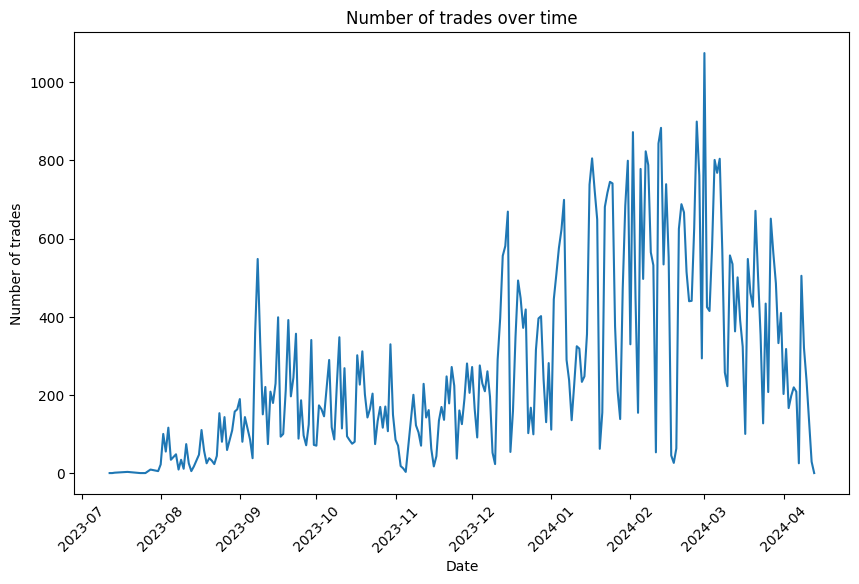

In [63]:
# plot num trades over time
plt.figure(figsize=(10,6))
all_trades['creation_timestamp'].dt.date.value_counts().sort_index().plot(title='Number of trades over time')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Number of trades')

In [64]:
print(all_trades['creation_timestamp'].min(), all_trades['creation_timestamp'].max())
all_trades['month_year'] = all_trades['creation_timestamp'].dt.to_period('M')
all_trades['month_year_week'] = all_trades['creation_timestamp'].dt.to_period('W')
all_trades['winning_trade'] = all_trades['winning_trade'].astype(int)

2023-07-12 15:17:25+00:00 2024-04-13 00:56:40+00:00


In [65]:
all_trades.columns

Index(['trader_address', 'trade_id', 'creation_timestamp', 'title',
       'market_status', 'collateral_amount', 'outcome_index',
       'trade_fee_amount', 'outcomes_tokens_traded', 'current_answer',
       'is_invalid', 'winning_trade', 'earnings', 'redeemed',
       'redeemed_amount', 'num_mech_calls', 'mech_fee_amount', 'net_earnings',
       'roi', 'month_year', 'month_year_week'],
      dtype='object')

In [66]:
all_trades.groupby(['month_year'])['winning_trade'].sum() / all_trades.groupby(['month_year'])['winning_trade'].count()

month_year
2023-07   0.385
2023-08   0.473
2023-09   0.442
2023-10   0.497
2023-11   0.488
2023-12   0.498
2024-01   0.470
2024-02   0.489
2024-03   0.499
2024-04   0.513
Freq: M, Name: winning_trade, dtype: float64

<Axes: title={'center': 'Winning trade percentage over time'}, xlabel='month_year_week'>

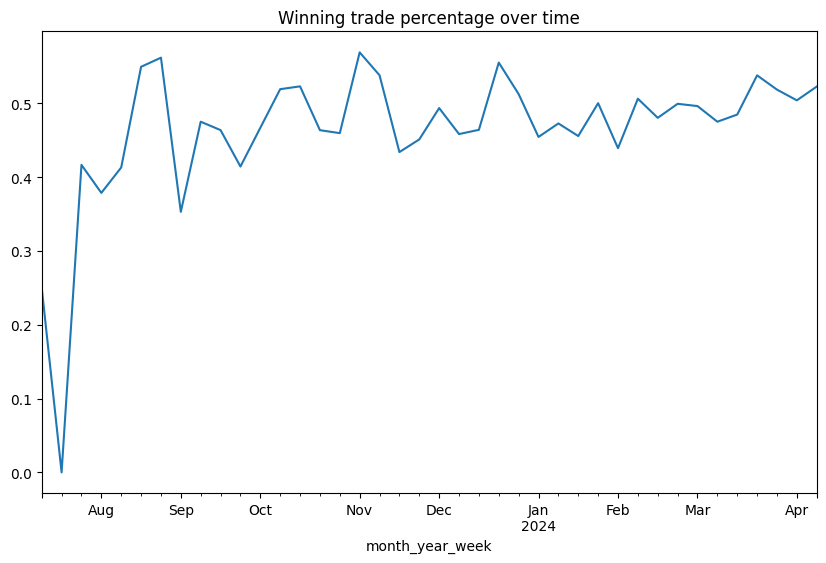

In [67]:
all_trades.groupby('month_year_week')['winning_trade'].mean().plot(title='Winning trade percentage over time', figsize=(10,6))

<Axes: title={'center': 'Mechanical calls over time'}, xlabel='month_year_week'>

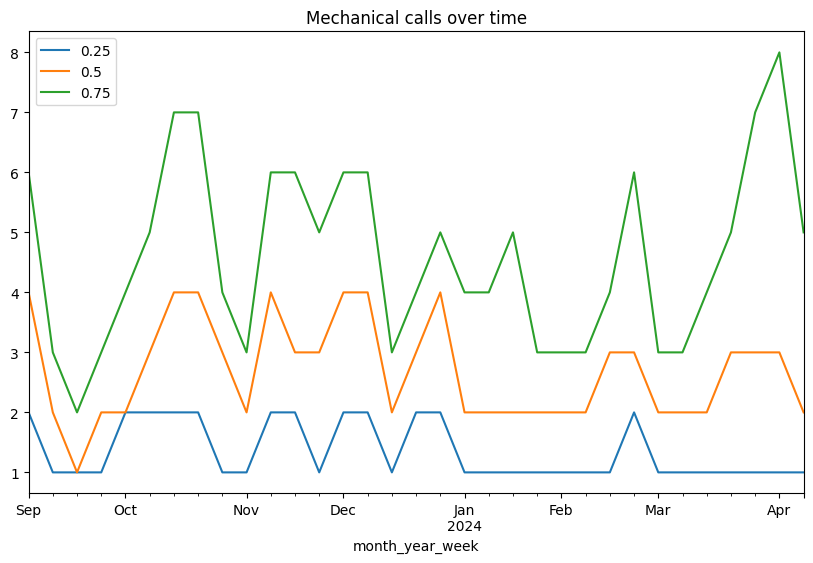

In [68]:
#only plot from september 2023
all_trades[all_trades['creation_timestamp'] > '2023-09-01'].groupby('month_year_week')['num_mech_calls'].quantile([0.25, 0.5, 0.75]).unstack().plot(title='Mechanical calls over time', figsize=(10,6)) 

<Axes: title={'center': 'Collateral amount quantiles over time'}, xlabel='month_year_week'>

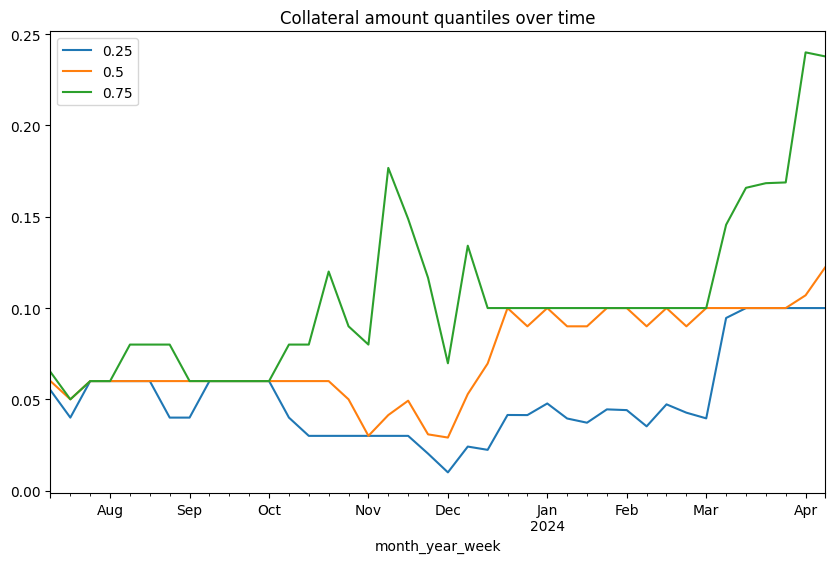

In [69]:
all_trades.groupby('month_year_week')['collateral_amount'].quantile([0.25, 0.5, 0.75]).unstack().plot(title='Collateral amount quantiles over time', figsize=(10,6))

<Axes: title={'center': 'Earnings quantiles over time'}, xlabel='month_year_week'>

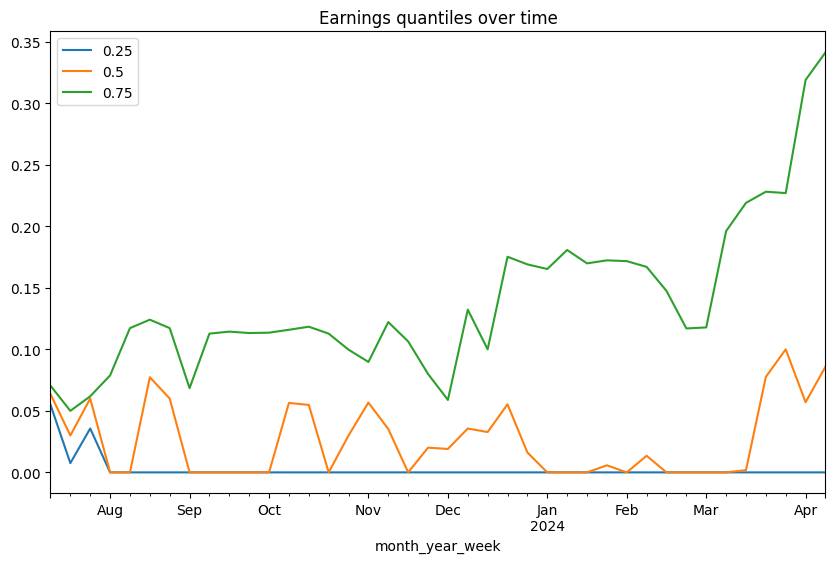

In [70]:
all_trades.groupby('month_year_week')['earnings'].quantile([0.25, 0.5, 0.75]).unstack().plot(title='Earnings quantiles over time', figsize=(10,6))

<Axes: title={'center': 'Net earnings quantiles over time'}, xlabel='month_year_week'>

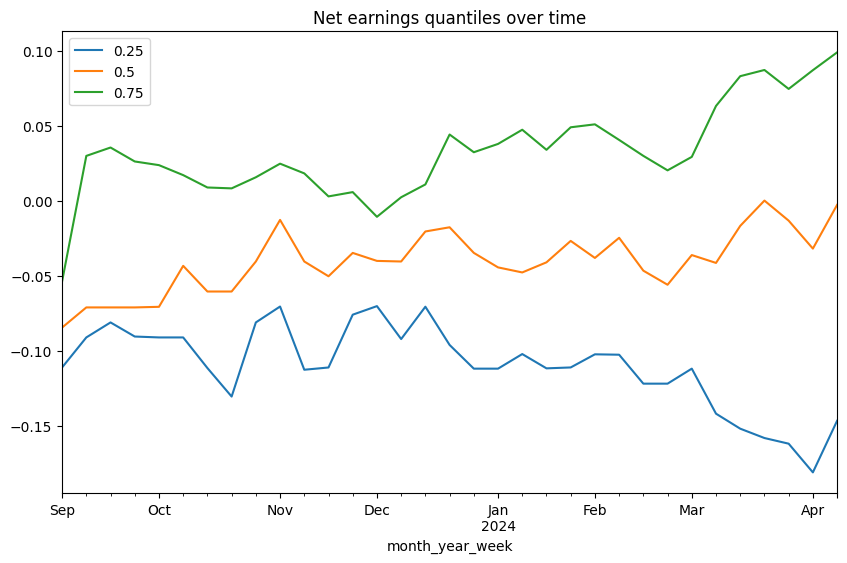

In [71]:
# plot new earnings from september 2023
all_trades[all_trades['creation_timestamp'] > '2023-09-01'].groupby('month_year_week')['net_earnings'].quantile([0.25, 0.5, 0.75]).unstack().plot(title='Net earnings quantiles over time', figsize=(10,6))

<Axes: title={'center': 'ROI quantiles over time'}, xlabel='month_year_week'>

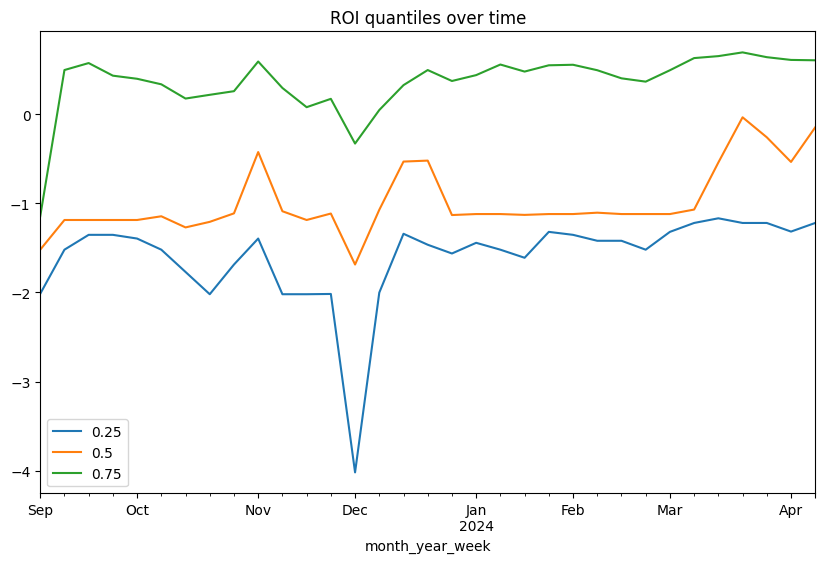

In [72]:
# roi from september 2023
all_trades[all_trades['creation_timestamp'] > '2023-09-01'].groupby('month_year_week')['roi'].quantile([0.25, 0.5, 0.75]).unstack().plot(title='ROI quantiles over time', figsize=(10,6))
